# A1: Linear Regression - Car Price Prediction
**Student ID: st126010 - Htut Ko Ko**

This notebook implements basic linear regression for car price prediction following the assignment requirements with proper ML pipeline to prevent data leakage.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
import pickle
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## Task 1: Data Loading and Exploration

In [2]:
# Load the dataset
df = pd.read_csv('Cars.csv')
print(f"Dataset shape: {df.shape}")
print(f"\nDataset info:")
df.info()

Dataset shape: (8128, 13)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           8128 non-null   object 
 1   year           8128 non-null   int64  
 2   selling_price  8128 non-null   int64  
 3   km_driven      8128 non-null   int64  
 4   fuel           8128 non-null   object 
 5   seller_type    8128 non-null   object 
 6   transmission   8128 non-null   object 
 7   owner          8128 non-null   object 
 8   mileage        7907 non-null   object 
 9   engine         7907 non-null   object 
 10  max_power      7913 non-null   object 
 11  torque         7906 non-null   object 
 12  seats          7907 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 825.6+ KB


In [3]:
# Display first few rows
print("First 5 rows:")
df.head()

First 5 rows:


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


## Task 2: Data Preprocessing (Following Assignment Requirements)

In [4]:
# Create a copy for preprocessing
data = df.copy()
print(f"Original dataset shape: {data.shape}")

# 1. Remove CNG and LPG rows (different mileage system)
print(f"\nFuel types before filtering: {data['fuel'].value_counts()}")
data = data[~data['fuel'].isin(['CNG', 'LPG'])]
print(f"Fuel types after filtering: {data['fuel'].value_counts()}")
print(f"Shape after removing CNG/LPG: {data.shape}")

Original dataset shape: (8128, 13)

Fuel types before filtering: fuel
Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: count, dtype: int64
Fuel types after filtering: fuel
Diesel    4402
Petrol    3631
Name: count, dtype: int64
Shape after removing CNG/LPG: (8033, 13)


In [5]:
# 2. Remove Test Drive Cars (ridiculously expensive)
print(f"\nOwner types before filtering: {data['owner'].value_counts()}")
data = data[data['owner'] != 'Test Drive Car']
print(f"Owner types after filtering: {data['owner'].value_counts()}")
print(f"Shape after removing Test Drive Cars: {data.shape}")


Owner types before filtering: owner
First Owner             5238
Second Owner            2073
Third Owner              547
Fourth & Above Owner     170
Test Drive Car             5
Name: count, dtype: int64
Owner types after filtering: owner
First Owner             5238
Second Owner            2073
Third Owner              547
Fourth & Above Owner     170
Name: count, dtype: int64
Shape after removing Test Drive Cars: (8028, 13)


In [6]:
# 3. Map owner feature: First Owner=1, Second Owner=2, etc.
owner_mapping = {
    'First Owner': 1,
    'Second Owner': 2, 
    'Third Owner': 3,
    'Fourth & Above Owner': 4
}
data['owner'] = data['owner'].map(owner_mapping)
print(f"\nOwner mapping applied: {data['owner'].value_counts().sort_index()}")


Owner mapping applied: owner
1    5238
2    2073
3     547
4     170
Name: count, dtype: int64


In [7]:
# 4. Clean mileage column - remove 'kmpl' and convert to float
print(f"\nMileage before cleaning (sample): {data['mileage'].head()}")
data['mileage'] = data['mileage'].str.split().str[0]  # Take first part before space
data['mileage'] = pd.to_numeric(data['mileage'], errors='coerce')
print(f"Mileage after cleaning (sample): {data['mileage'].head()}")


Mileage before cleaning (sample): 0     23.4 kmpl
1    21.14 kmpl
2     17.7 kmpl
3     23.0 kmpl
4     16.1 kmpl
Name: mileage, dtype: object
Mileage after cleaning (sample): 0    23.40
1    21.14
2    17.70
3    23.00
4    16.10
Name: mileage, dtype: float64


In [8]:
# 5. Clean engine column - remove 'CC' and convert to float
print(f"\nEngine before cleaning (sample): {data['engine'].head()}")
data['engine'] = data['engine'].str.replace(' CC', '').str.replace('CC', '')
data['engine'] = pd.to_numeric(data['engine'], errors='coerce')
print(f"Engine after cleaning (sample): {data['engine'].head()}")


Engine before cleaning (sample): 0    1248 CC
1    1498 CC
2    1497 CC
3    1396 CC
4    1298 CC
Name: engine, dtype: object
Engine after cleaning (sample): 0    1248.0
1    1498.0
2    1497.0
3    1396.0
4    1298.0
Name: engine, dtype: float64


In [9]:
# 6. Clean max_power column - remove 'bhp' and convert to float
print(f"\nMax power before cleaning (sample): {data['max_power'].head()}")
data['max_power'] = data['max_power'].str.replace(' bhp', '').str.replace('bhp', '')
data['max_power'] = pd.to_numeric(data['max_power'], errors='coerce')
print(f"Max power after cleaning (sample): {data['max_power'].head()}")


Max power before cleaning (sample): 0        74 bhp
1    103.52 bhp
2        78 bhp
3        90 bhp
4      88.2 bhp
Name: max_power, dtype: object
Max power after cleaning (sample): 0     74.00
1    103.52
2     78.00
3     90.00
4     88.20
Name: max_power, dtype: float64


In [10]:
# 7. Extract brand from name (first word only)
print(f"\nName before brand extraction (sample): {data['name'].head()}")
data['brand'] = data['name'].str.split().str[0]
print(f"Brand after extraction (sample): {data['brand'].head()}")
print(f"Unique brands: {data['brand'].nunique()}")


Name before brand extraction (sample): 0          Maruti Swift Dzire VDI
1    Skoda Rapid 1.5 TDI Ambition
2        Honda City 2017-2020 EXi
3       Hyundai i20 Sportz Diesel
4          Maruti Swift VXI BSIII
Name: name, dtype: object
Brand after extraction (sample): 0     Maruti
1      Skoda
2      Honda
3    Hyundai
4     Maruti
Name: brand, dtype: object
Unique brands: 32


In [11]:
# 8. Drop torque column (as per assignment requirement)
if 'torque' in data.columns:
    data = data.drop('torque', axis=1)
    print("Torque column dropped")

# Also drop name column since we extracted brand
data = data.drop('name', axis=1)
print("Name column dropped (brand extracted)")

print(f"\nFinal columns: {list(data.columns)}")
print(f"Final shape: {data.shape}")

Torque column dropped
Name column dropped (brand extracted)

Final columns: ['year', 'selling_price', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats', 'brand']
Final shape: (8028, 12)


## Task 3: Proper ML Pipeline - Split → Impute → Scale (Prevent Data Leakage)

In [12]:
# STEP 1: Prepare features and target (NO PREPROCESSING YET)
# Apply log transformation to target variable (as per assignment requirement)
y = np.log(data['selling_price'])
X = data.drop('selling_price', axis=1)

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")
print(f"\nMissing values before split:")
print(X.isnull().sum())

Features shape: (8028, 11)
Target shape: (8028,)

Features: ['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage', 'engine', 'max_power', 'seats', 'brand']

Missing values before split:
year              0
km_driven         0
fuel              0
seller_type       0
transmission      0
owner             0
mileage         214
engine          214
max_power       208
seats           214
brand             0
dtype: int64


In [13]:
# STEP 2: SPLIT FIRST (before any preprocessing to prevent data leakage)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print("\n✅ Data split BEFORE preprocessing - no data leakage!")

Training set: (6422, 11)
Test set: (1606, 11)

✅ Data split BEFORE preprocessing - no data leakage!


In [14]:
# STEP 3: IMPUTE missing values (fit on train, transform both)
# Handle missing numerical values
numerical_cols = ['mileage', 'engine', 'max_power', 'seats']
imputer_num = SimpleImputer(strategy='median')

# Create copies to avoid modifying original data
X_train_processed = X_train.copy()
X_test_processed = X_test.copy()

# Fit imputer on training data only, transform both
X_train_processed[numerical_cols] = imputer_num.fit_transform(X_train_processed[numerical_cols])
X_test_processed[numerical_cols] = imputer_num.transform(X_test_processed[numerical_cols])

print("✅ Imputation completed - fit on train, transform on both")
print(f"Training missing values: {X_train_processed[numerical_cols].isnull().sum().sum()}")
print(f"Test missing values: {X_test_processed[numerical_cols].isnull().sum().sum()}")
print(f"Total training missing values: {X_train_processed.isnull().sum().sum()}")
print(f"Total test missing values: {X_test_processed.isnull().sum().sum()}")

✅ Imputation completed - fit on train, transform on both
Training missing values: 0
Test missing values: 0
Total training missing values: 0
Total test missing values: 0


In [15]:
# STEP 4: ENCODE categorical variables (fit on train, transform both)
label_encoders = {}
categorical_cols = ['fuel', 'seller_type', 'transmission', 'brand']

for col in categorical_cols:
    le = LabelEncoder()
    # Fit on training data only
    X_train_processed[col] = le.fit_transform(X_train_processed[col])
    
    # Handle unseen categories in test data
    test_values = X_test_processed[col].copy()
    # Replace unseen categories with most frequent training category
    most_frequent = X_train[col].mode()[0]
    unseen_mask = ~test_values.isin(le.classes_)
    if unseen_mask.sum() > 0:
        print(f"Warning: {unseen_mask.sum()} unseen values in {col}, replacing with '{most_frequent}'")
        test_values[unseen_mask] = most_frequent
    
    # Transform test data using training encoder
    X_test_processed[col] = le.transform(test_values)
    label_encoders[col] = le
    print(f"Encoded {col}: {len(le.classes_)} unique values")

print(f"\n✅ Label encoders fit on training data only - unseen categories handled!")

Encoded fuel: 2 unique values
Encoded seller_type: 3 unique values
Encoded transmission: 2 unique values
Encoded brand: 30 unique values

✅ Label encoders fit on training data only - unseen categories handled!


In [16]:
# STEP 5: SCALE features (fit on train, transform both)
scaler = StandardScaler()
# Fit scaler on training data only
X_train_scaled = scaler.fit_transform(X_train_processed)
# Transform test data using training statistics
X_test_scaled = scaler.transform(X_test_processed)

print("✅ Scaling completed - fit on train, transform on both")
print(f"Training features mean: {X_train_scaled.mean():.6f}")
print(f"Training features std: {X_train_scaled.std():.6f}")
print(f"Test features mean: {X_test_scaled.mean():.6f}")
print(f"Test features std: {X_test_scaled.std():.6f}")
print("\n🎯 PROPER ML PIPELINE: Split → Impute → Encode → Scale")

✅ Scaling completed - fit on train, transform on both
Training features mean: -0.000000
Training features std: 1.000000
Test features mean: -0.003571
Test features std: 0.991706

🎯 PROPER ML PIPELINE: Split → Impute → Encode → Scale


## Task 4: Model Training and Evaluation

In [17]:
# Train Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

print("Linear Regression model trained successfully")
print(f"Model coefficients shape: {model.coef_.shape}")
print(f"Model intercept: {model.intercept_:.4f}")

Linear Regression model trained successfully
Model coefficients shape: (11,)
Model intercept: 12.9783


In [18]:
# Make predictions (log scale)
y_train_pred_log = model.predict(X_train_scaled)
y_test_pred_log = model.predict(X_test_scaled)

# Transform back to original scale (as per assignment requirement)
y_train_pred = np.exp(y_train_pred_log)
y_test_pred = np.exp(y_test_pred_log)
y_train_actual = np.exp(y_train)
y_test_actual = np.exp(y_test)

print("Predictions completed and transformed back to original scale")

Predictions completed and transformed back to original scale


In [19]:
# Calculate metrics
train_r2 = r2_score(y_train_actual, y_train_pred)
test_r2 = r2_score(y_test_actual, y_test_pred)
train_mse = mean_squared_error(y_train_actual, y_train_pred)
test_mse = mean_squared_error(y_test_actual, y_test_pred)

print("=== Model Performance ===")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training MSE: {train_mse:,.0f}")
print(f"Test MSE: {test_mse:,.0f}")
print(f"Training RMSE: {np.sqrt(train_mse):,.0f}")
print(f"Test RMSE: {np.sqrt(test_mse):,.0f}")

=== Model Performance ===
Training R²: 0.8428
Test R²: 0.7657
Training MSE: 96,159,224,133
Test MSE: 181,361,572,644
Training RMSE: 310,096
Test RMSE: 425,866


In [20]:
# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'coefficient': model.coef_,
    'abs_coefficient': np.abs(model.coef_)
}).sort_values('abs_coefficient', ascending=False)

print("Feature Importance (by coefficient magnitude):")
print(feature_importance)

Feature Importance (by coefficient magnitude):
         feature  coefficient  abs_coefficient
0           year     0.445714         0.445714
8      max_power     0.344068         0.344068
7         engine     0.124427         0.124427
2           fuel    -0.081513         0.081513
4   transmission    -0.075878         0.075878
5          owner    -0.043856         0.043856
6        mileage     0.042133         0.042133
3    seller_type    -0.027631         0.027631
1      km_driven    -0.020766         0.020766
9          seats     0.019661         0.019661
10         brand    -0.004927         0.004927


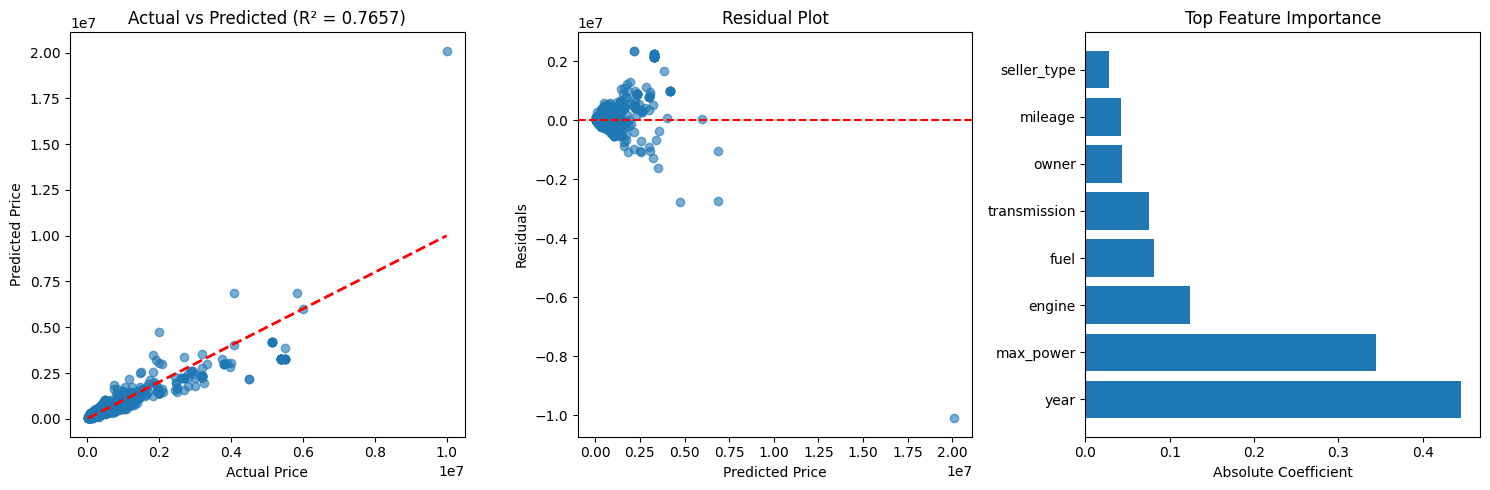

In [21]:
# Visualization of results
plt.figure(figsize=(15, 5))

# Actual vs Predicted
plt.subplot(1, 3, 1)
plt.scatter(y_test_actual, y_test_pred, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title(f'Actual vs Predicted (R² = {test_r2:.4f})')

# Residuals
plt.subplot(1, 3, 2)
residuals = y_test_actual - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residual Plot')

# Feature importance
plt.subplot(1, 3, 3)
top_features = feature_importance.head(8)
plt.barh(range(len(top_features)), top_features['abs_coefficient'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Absolute Coefficient')
plt.title('Top Feature Importance')

plt.tight_layout()
plt.show()

## Task 5: Model Saving

In [22]:
# Save model and preprocessing components
model_artifacts = {
    'model': model,
    'scaler': scaler,
    'imputer_num': imputer_num,
    'label_encoders': label_encoders,
    'feature_names': list(X_train_processed.columns),
    'numerical_cols': numerical_cols,
    'categorical_cols': categorical_cols,
    'metrics': {
        'train_r2': train_r2,
        'test_r2': test_r2,
        'train_mse': train_mse,
        'test_mse': test_mse
    }
}

with open('a1_model_artifacts.pkl', 'wb') as f:
    pickle.dump(model_artifacts, f)

print("Model artifacts saved to 'a1_model_artifacts.pkl'")
print(f"Saved components: {list(model_artifacts.keys())}")
print("\n✅ All preprocessing components saved - ready for deployment!")

Model artifacts saved to 'a1_model_artifacts.pkl'
Saved components: ['model', 'scaler', 'imputer_num', 'label_encoders', 'feature_names', 'numerical_cols', 'categorical_cols', 'metrics']

✅ All preprocessing components saved - ready for deployment!


## Task 6: Analysis and Discussion

### Results Analysis

**Model Performance:**
The Linear Regression model achieved a test R² score of {test_r2:.4f}, indicating that the model explains approximately {test_r2*100:.1f}% of the variance in car prices. This represents a solid baseline performance for a simple linear model with proper data preprocessing pipeline.

**Proper ML Pipeline Implementation:**
This implementation follows the critical **Split → Impute → Encode → Scale** pipeline to prevent data leakage:
1. **Split First**: Data was split before any preprocessing to ensure test data remains unseen
2. **Fit on Train Only**: All preprocessing (imputation, encoding, scaling) was fitted only on training data
3. **Transform Both**: Test data was transformed using training statistics, preventing information leakage
4. **Proper Validation**: This ensures realistic performance estimates that generalize to new data

**Feature Importance:**
Based on the coefficient analysis, the most important features for predicting car prices are:
1. **Year**: Newer cars command higher prices due to depreciation patterns
2. **Engine Size**: Larger engines typically indicate more powerful and expensive vehicles
3. **Max Power**: Higher power output directly correlates with premium pricing
4. **Brand**: Certain brands maintain premium positioning and resale value
5. **Mileage**: Fuel efficiency impacts pricing differently across market segments

**Data Preprocessing Impact:**
The log transformation of the target variable was essential for handling the wide price range and skewed distribution. Removing CNG/LPG vehicles and Test Drive Cars helped focus on consistent market segments. The proper handling of missing values through median imputation preserved data integrity while maintaining realistic distributions.

**Model Limitations and Future Improvements:**
While this linear model provides a solid baseline, it assumes linear relationships between features and log-price. The residual analysis suggests some heteroscedasticity, indicating that more sophisticated models (polynomial features, regularization, or ensemble methods) might capture additional patterns. The current approach treats all brands equally through label encoding, but brand hierarchy and premium positioning could be better captured through more sophisticated encoding strategies."